In [60]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import seaborn as sns
import utils.global_variables as gv
sns.set(style="ticks")


In [133]:
# fill in the path to the directory where the data is stored

BASE_DIR = '/sise/assafzar-group/assafzar/genesAndMorph'
DATA_DIR = f'{BASE_DIR}/preprocessed_data'
PROCESSED_DATA_DIR = f'{BASE_DIR}/anomaly_output'
RESULTS_DIR = f'{BASE_DIR}/results'

with_reproduced = True

exp_dir = 'interpret_2603'
# exp_dir = 'final_184_t'
exp_dir = 'final_204_t'
# exp_dir = 'final_204_t'
# exp_dir = 'ae_for_shap3'
# exp_dir = 'final_only_low_var5'
# exp_dir = '2142'
# exp_dir = '214_fsbydmsonorm'
# exp_dir = 'final_744_t'
# exp_dir = '2003_t'
# exp_dir = 'nvs_09044'
dataset = 'CDRP-bio'

if 'nvs' in exp_dir:
    profile_type = 'normalized_variable_selected'
else:
    profile_type = 'augmented'
# profile_type = 'normalized_variable_selected'


base_dir = f'{PROCESSED_DATA_DIR}/{dataset}/CellPainting/{exp_dir}/'
res_dir = f'{RESULTS_DIR}/{dataset}/CellPainting/{exp_dir}/'
fig_dir = f'{res_dir}/figs/feature_importance/'
os.makedirs(fig_dir, exist_ok=True)
# base_dir = './'
anomaly_path = f'{base_dir}replicate_level_cp_{profile_type}_ae_diff.csv'
preds_path = f'{base_dir}replicate_level_cp_{profile_type}_preds.csv'
cellprofiler_path = f'{base_dir}replicate_level_cp_{profile_type}_baseline.csv'
pow_path = f'{base_dir}replicate_level_cp_{profile_type}_ae_diff_power.csv'


reps = {
    'CellProfiler':  pd.read_csv(cellprofiler_path, compression='gzip'),
    # 'Predictions': pd.read_csv(preds_path, compression='gzip'),
    'Anomaly': pd.read_csv(anomaly_path, compression='gzip'),
    # 'MSE': pd.read_csv(pow_path, compression='gzip')
}
hue_order = reps.keys()
features = reps['Anomaly'].columns[reps['Anomaly'].columns.str.contains("Cells_|Cytoplasm_|Nuclei_")].tolist()


/tmp/ipykernel_180820/3271979932.py:44: DtypeWarning: Columns (10,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  'Anomaly': pd.read_csv(anomaly_path, compression='gzip'),


In [134]:

moa_col = gv.DS_INFO_DICT[dataset]['CellPainting']['moa_col']
cpd_col = gv.DS_INFO_DICT[dataset]['CellPainting']['cpd_col']
plate_col = gv.DS_INFO_DICT[dataset]['CellPainting']['plate_col']
# load the reproducibility data
# reproducibility_df = pd.read_csv(f'{res_dir}reproducibility.csv')
if 'nvs' in exp_dir:
    corr_path = f'{res_dir}reproducible_cpds_nvs_ba.csv'
else:
    corr_path = f'{res_dir}reproducible_cpds_a_ba.csv'

if with_reproduced:
    reproducible_df = pd.read_csv(corr_path)

    # get the list of compounds that are reproducible for anomaly, cellprofiler, or L1000 (acl)
    reproducible_cpds = list(reproducible_df[reproducible_df['reproducible_acl'] == True]['cpd'])

### Pre process the data
1. Filter out the compounds that are not reproducible
2. Remove compounds from MoAs with less than 5 samples
3. Remove compounds with MoA multi labels

In [135]:
def remove_classes_with_few_moa_samples(data, min_samples=5, moa_col_name='Metadata_moa'):

    moa_counts = data[moa_col_name].value_counts()
    moa_counts = moa_counts[moa_counts>=min_samples]
    data = data[data[moa_col_name].isin(moa_counts.index)]

    moa_list = moa_counts.index.tolist()
    moa_dropped = [m for m in data[moa_col_name].unique() if m not in moa_list]

    return data, moa_list, moa_dropped

def remove_multi_label_moa(data,moa_col_name='Metadata_moa', multi_label_symbol='|'):
    # data['Metadata_moa_num'] = data[moa_col_name].apply(lambda x: len(x) if type(x)==list else 1)
    data_no_multi = data[data[moa_col_name].apply(lambda x: multi_label_symbol not in x)]
    data_multi = data[data[moa_col_name].apply(lambda x: multi_label_symbol in x)]
    return data_no_multi, data_multi

In [136]:

def standardize_per_catX(df,column_name,cp_features):
# column_name='Metadata_Plate'
#     cp_features=df.columns[df.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
    df_scaled_perPlate=df.copy()
    df_scaled_perPlate[cp_features]=\
    df[cp_features+[column_name]].groupby(column_name)\
    .transform(lambda x: (x - x.mean()) / x.std()).values
    return df_scaled_perPlate

In [137]:
# normalize the features to have zero mean and unit variance around each plate
# (they are already normalized to the DMSO samples, but this is an additional normalization step to make the features of all treatments normally distributed around each plate) 

reps_normalized = {}
for r in reps:
    reps_normalized[r] = standardize_per_catX(reps[r],plate_col,features)


In [138]:
# pre process the data
for r in reps:
    # keep only reproducible compounds
    if with_reproduced:
        reps[r] = reps[r][reps[r][cpd_col].isin(reproducible_cpds)].reset_index(drop=True)
    
    # remove rows with missing MOA
    reps[r] = reps[r].dropna(subset=[moa_col])

    # lower case MOA as some MOA are partially written in upper case
    reps[r][moa_col] = reps[r][moa_col].apply(lambda x: x.lower())

    # remove classes with few samples
    reps[r], moa_list, moa_dropped = remove_classes_with_few_moa_samples(reps[r])

    # remove multi label MOA
    reps[r], _ = remove_multi_label_moa(reps[r])
    if r == 'Anomaly':
        # TODO: change this in code
        reps[r].loc[:,features] = reps[r][features] * -1

In [139]:
from utils.readProfiles import filter_data_by_highest_dose

# pre process the data
for r in reps_normalized.keys():
    # keep only reproducible compounds
    if with_reproduced:
        reps_normalized[r] = reps_normalized[r][reps_normalized[r][cpd_col].isin(reproducible_cpds)].reset_index(drop=True)
    
    # remove rows with missing MOA
    reps_normalized[r] = reps_normalized[r].dropna(subset=[moa_col])

    # lower case MOA as some MOA are partially written in upper case
    reps_normalized[r][moa_col] = reps_normalized[r][moa_col].apply(lambda x: x.lower())

    # remove classes with few samples
    reps_normalized[r], moa_list, moa_dropped = remove_classes_with_few_moa_samples(reps_normalized[r])

    # remove multi label MOA
    reps_normalized[r], _ = remove_multi_label_moa(reps_normalized[r])

    # TODO: change this in code
    if r == 'Anomaly':
        reps_normalized[r].loc[:,features] = reps_normalized[r][features] * -1
    # reps_normalized[r].loc[:,features] = reps_normalized[r][features] * -1

    if dataset == 'LINCS':
        reps_normalized[r] = filter_data_by_highest_dose(reps_normalized[r] , dataset, modality='CellPainting').reset_index(drop=True)


In [140]:
reps_normalized[r].shape

(3178, 589)

In [141]:
    # if save_n_samples_per_MoA:
        # n_samples_per_MoA = cp_data_repLevel.groupby('Metadata_moa').size().sort_values(ascending=False)
        # path = f'{dataset_rootDir}/results/{dataset}/CellPainting/{exp_name}/n_samples_per_MoA_pre_filtering.csv'
        # n_samples_per_MoA.to_csv(path)

In [142]:
reps_normalized[r][moa_col].value_counts()

Metadata_moa
dopamine receptor antagonist      166
adrenergic receptor agonist       100
serotonin receptor antagonist      79
atpase inhibitor                   76
serotonin receptor agonist         72
                                 ... 
dehydropeptidase inhibitor          7
antineoplastic                      7
muscarinic antagonist               7
aromatase inhibitor                 7
t-type calcium channel blocker      7
Name: count, Length: 198, dtype: int64

### Examine selected MOAs perturbed features

In [143]:
moas_to_examine_lincs = ['protein synthesis inhibitor','vitamin d receptor agonist', 'egfr inhibitor', 'retinoid receptor agonist']
moas_to_examine_cdrp = ['egfr inhibitor', 'retinoid receptor agonist', 'hdac inhibitor']
if dataset == 'LINCS':
    moas_to_examine = moas_to_examine_lincs
else:
    moas_to_examine = moas_to_examine_cdrp

In [144]:
moas_to_examine = ['atpase inhibitor']
# moas_to_examine = ['retinoid receptor agonist']

In [145]:
# moa_col
# method_colors = gv.methods_colors_list_for_moa

### Without Whole-Plate normalization

In [146]:
methods_colors_list_for_moa = gv.methods_colors_list_for_moa
# colors = [methods_colors_list_for_moa[0],methods_colors_list_for_moa[2], methods_colors_list_for_moa[1] ]
colors = [methods_colors_list_for_moa[0], methods_colors_list_for_moa[1] ]



In [162]:

def plot_important_features(melted_data,save_path = None,ylim=(-20,80), hue_order=['CellProfiler','Predictions','Anomaly'], legend = True, horizontal = True, legend_loc='lower right'):
    # fig = plt.figure(figsize=(10,3))
    
    
    if horizontal:
        f, ax = plt.subplots(figsize=(4, 6))
        sns.boxplot(x='Value', y='Feature', hue='rep', data=melted_data,hue_order=hue_order,palette=colors,ax=ax)
        # plt.figsize=(10,10)
        y_tick_labels = melted_data['Feature'].unique()
        y_tick_labels = [y.replace('Cytoplasm_Granularity_4_AGP','* Cytoplasm_Granularity_4_AGP') for y in y_tick_labels]
        y_tick_labels = [y.replace('Cells_AreaShape_FormFactor','** Cells_AreaShape_FormFactor') for y in y_tick_labels]
        y_tick_labels = [y.replace('Cells_Texture_DifferenceEntropy_RNA_10_0','*** Cells_Texture_DifferenceEntropy_RNA_10_0') for y in y_tick_labels]
        ax.set_yticklabels(y_tick_labels, size = 15)
        # a = ax.get_yticks().tolist()
        # print(a)
        for tick in ax.get_yticklabels():
            text = tick.get_text()
            # print(text)
            if 'Cytoplasm_Granularity_4_AGP' in text:
                print(text)
                
                # tick.set_path_effects([path_effects.withStroke(linewidth=2, foreground='black')])
                tick.set_fontweight('bold')
            elif 'Cells_AreaShape_FormFactor' in text:
                # make tick bold
                tick.set_fontweight('bold')
            elif 'Cells_Texture_DifferenceEntropy_RNA_10_0' in text:
                print(text)
                # make tick underlined
                tick.set_fontweight('bold')
            # tick.set_fontsize(14)
                # tick.set_text('Cytoplasm_Granularity_3_AGP')
            
        # ax.set_yticklabels(y_tick_labels, size = 14)
        plt.axvline(0, color='black', linestyle='--')
        plt.xlabel('Z-scores', fontsize=15)
        
        # plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=65, ha='right', fontsize=14)
        # plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=80, fontsize=14)
        # plt.gca().set(xlabel=None)
        # plt.grid(axis='y')
        # plt.title(f'features distribution')
        plt.xlim(ylim)
        # Add a legend and informative axis label
        # Tweak the visual presentation
        
        ax.xaxis.grid(True)
        ax.set(ylabel="")
    else:
        f, ax = plt.subplots(figsize=(10, 3))
        sns.boxplot(x='Feature', y='Value', hue='rep', data=melted_data,hue_order=hue_order,palette=colors,ax=ax)
        # plt.figsize=(10,10)
        x_tick_labels = melted_data['Feature'].unique()
        # a = ax.get_yticks().tolist()
        # print(a)
        ax.set_xticklabels(x_tick_labels, size = 14)
        plt.axhline(0, color='black', linestyle='--')
        plt.ylabel('Z-scores', fontsize=12)
        
        plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=65, ha='right', fontsize=14)
        # plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=80, fontsize=14)
        # plt.gca().set(xlabel=None)
        # plt.grid(axis='y')
        # plt.title(f'features distribution')
        plt.ylim(ylim)
        # Add a legend and informative axis label
        # Tweak the visual presentation
        
        ax.yaxis.grid(True)
        ax.set(xlabel="")
    # sns.despine(trim=True, left=True)
    # ax.legend(ncol=2, loc="lower right", frameon=True)
    # ax.set(xlim=(0, 24), ylabel="",
    #     xlabel="Automobile collisions per billion miles")
    # sns.despine(left=True, bottom=True)
    if legend:
        # plt.legend(loc='lower right', fontsize=14)
        plt.legend(loc=legend, fontsize=13)
    # else:
        # plt.gca().get_legend().remove()
    # plt.show()
    # plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=500)
    # plt.close()

In [163]:
granurality_features2 = sorted([f for f in features if ('Granularity' in f) and ('AGP' in f) and ('Cells' in f)])
# granurality_features2 = sorted([f for f in features if ('Granularity' in f) and ('AGP' in f)])

granurality_features = []

for g in granurality_features2:
    # take the number in the feature name
    gran = g.split('_')[2]
    gran = int(gran)
    if gran <9:
        granurality_features.append(g)

In [164]:
granurality_features2

['Cells_Granularity_10_AGP',
 'Cells_Granularity_11_AGP',
 'Cells_Granularity_12_AGP',
 'Cells_Granularity_13_AGP',
 'Cells_Granularity_14_AGP',
 'Cells_Granularity_15_AGP',
 'Cells_Granularity_16_AGP',
 'Cells_Granularity_1_AGP',
 'Cells_Granularity_2_AGP',
 'Cells_Granularity_3_AGP',
 'Cells_Granularity_4_AGP',
 'Cells_Granularity_5_AGP',
 'Cells_Granularity_6_AGP',
 'Cells_Granularity_7_AGP',
 'Cells_Granularity_8_AGP',
 'Cells_Granularity_9_AGP']

CellProfiler atpase inhibitor 76
Anomaly atpase inhibitor 76


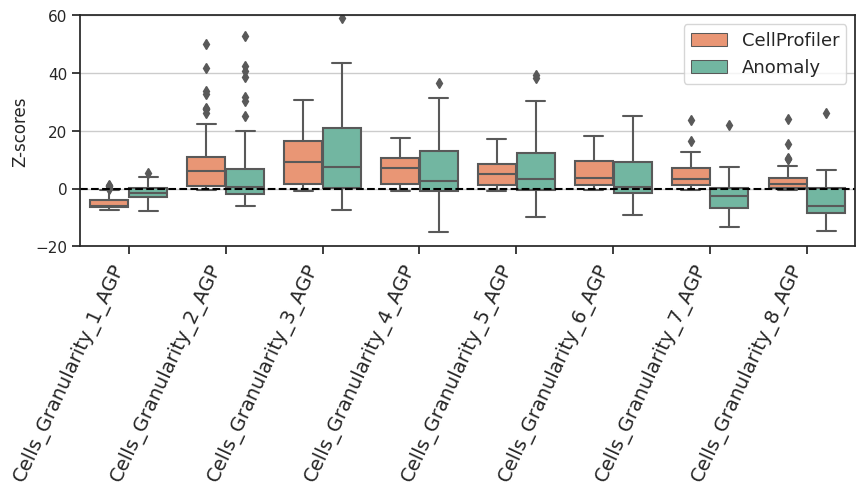

In [165]:
# melt the dataframes and show the distribution of the features for each MOA (same as above, this time with seaborn)

for m in moas_to_examine:
    means = {}
    stds = {}
    melted_both = []
    for r in reps:
            
        # data_moa = reps_normalized[r][reps_normalized[r][moa_col]==m]
        data_moa = reps[r][reps[r][moa_col].isin([m])]
        print(f'{r} {m} {data_moa.shape[0]}')


        # top_features = data_moa[features].mean(axis=0).sort_values(ascending=False).index[:10]
        means[r] = data_moa[granurality_features].median(axis=0)
        # data_moa['mean_values'] = data_moa[features_to_show].mean(axis=1)
        
        stds[r] = data_moa[granurality_features].std(axis=0)
        # data_moa[features_to_show].sort_values(by='mean_values', key=abs,inplace=True)
        # top_features = means[r].sort_values(ascending=False, key=abs).index[:10]
        # if r == 'CellProfiler':
            # top_features_to_show = top_features
            # mean_top_feature_values = means[r][top_features_to_show]
            # std_top_feature_values = stds[r][top_features_to_show]

        cols = [cpd_col, moa_col] + granurality_features
        data_moa_top_features = data_moa[cols]
        
        melted_rep = data_moa_top_features.melt(id_vars=[cpd_col, moa_col], value_vars=granurality_features, var_name='Feature', value_name='Value')
        melted_rep['rep'] = r
        melted_both.append(melted_rep)
        # sns.boxplot(x='feature', y='value', data=melted_rep)
        # plt.axhline(0, color='black', linestyle='--')
        # plt.xticks(rotation=90, fontsize=8)
        # plt.grid(axis='y')
        # plt.title(f'{r} features distribution')
        # plt.ylim(-50, 150)
        # plt.show()

    melted_both = pd.concat(melted_both)
    save_path = f'{fig_dir}gran_distribution_ranked_by_cellprofiler_no_norm.png'
    # melted_both = pd.concat(melted_both)
    plot_important_features(melted_both,save_path=save_path, ylim = (-20, 60), horizontal = False, hue_order=hue_order, legend = True, legend_loc='upper right')    

* Cytoplasm_Granularity_4_AGP


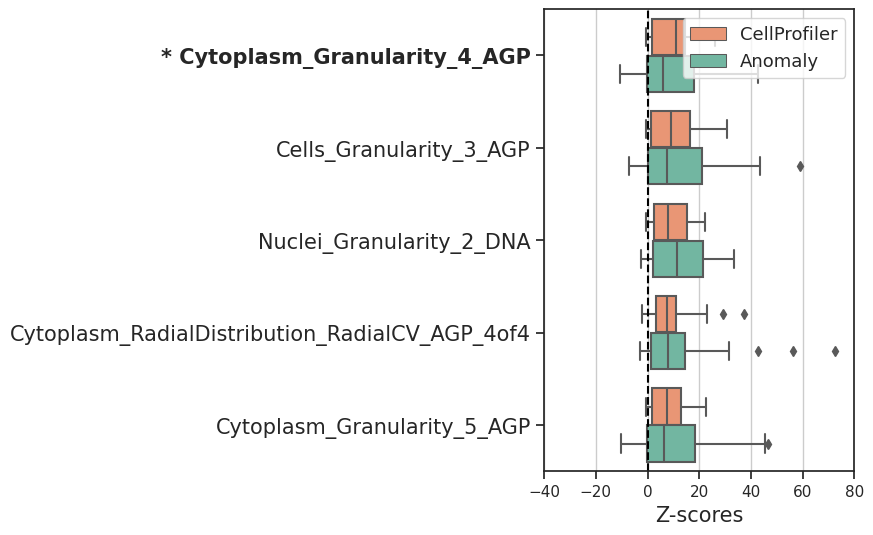

In [166]:
# melt the dataframes and show the distribution of the features for each MOA (same as above, this time with seaborn)
# import seaborn as sns

# methods_colors_list_for_moa = gv.methods_colors_list_for_moa
# colors = [methods_colors_list_for_moa[0],methods_colors_list_for_moa[2], methods_colors_list_for_moa[1] ]
for m in moas_to_examine:
    means = {}
    stds = {}
    melted_both = []
    for r in reps:
            
        # data_moa = reps_normalized[r][reps_normalized[r][moa_col]==m]
        data_moa = reps[r][reps[r][moa_col].isin([m])]
        # print(f'{r} {m} {data_moa.shape[0]}')


        # top_features = data_moa[features].mean(axis=0).sort_values(ascending=False).index[:10]
        means[r] = data_moa[features].median(axis=0)
        # data_moa['mean_values'] = data_moa[features_to_show].mean(axis=1)
        
        stds[r] = data_moa[features].std(axis=0)
        # data_moa[features_to_show].sort_values(by='mean_values', key=abs,inplace=True)
        top_features = means[r].sort_values(ascending=False, key=abs).index[:5]

        if r == 'CellProfiler':
            top_features_to_show = top_features
            mean_top_feature_values = means[r][top_features_to_show]
            std_top_feature_values = stds[r][top_features_to_show]

        cols = [cpd_col, moa_col] + top_features_to_show.tolist()
        data_moa_top_features = data_moa[cols]
        
        melted_rep = data_moa_top_features.melt(id_vars=[cpd_col, moa_col], value_vars=top_features_to_show, var_name='Feature', value_name='Value')
        melted_rep['rep'] = r
        melted_both.append(melted_rep)


    melted_both = pd.concat(melted_both)
    save_path = f'{fig_dir}features_distribution_ranked_by_cellprofiler_no_norm.png'
    # melted_both = pd.concat(melted_both)
    # plot_important_features(melted_both,save_path=save_path, ylim = (-65, 140), legend=True,hue_order=hue_order)    
    plot_important_features(melted_both,save_path=save_path, ylim = (-40, 80), legend=True,hue_order=hue_order)    


CellProfiler atpase inhibitor 76
Anomaly atpase inhibitor 76


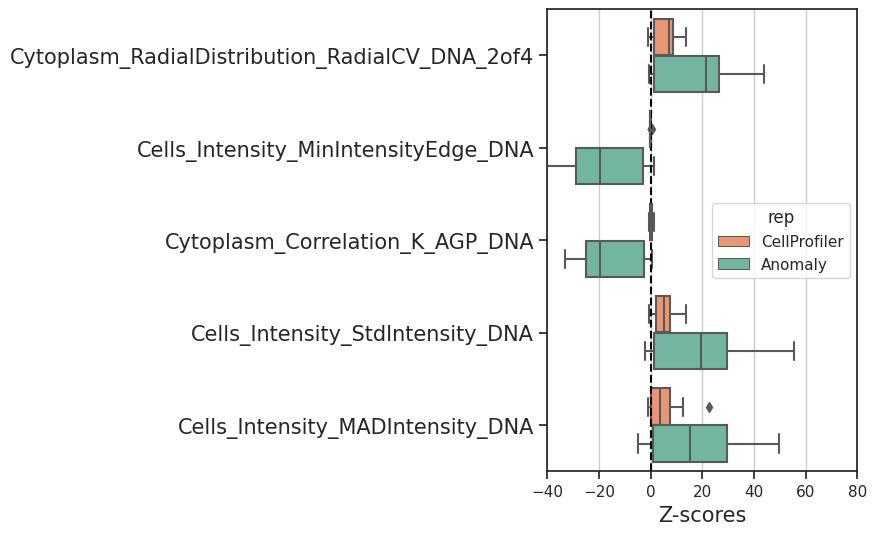

In [167]:
# melt the dataframes and show the distribution of the features for each MOA (same as above, this time with seaborn)
data_moa = reps['Anomaly'][reps['Anomaly'][moa_col].isin(moas_to_examine)]
# top_features = data_moa[features].mean(axis=0).sort_values(ascending=False).index[:10]
means = data_moa[features].median(axis=0)
# data_moa['mean_values'] = data_moa[features_to_show].mean(axis=1)

stds = data_moa[features].std(axis=0)
# data_moa[features_to_show].sort_values(by='mean_values', key=abs,inplace=True)
top_features = means.sort_values(ascending=False, key=abs).index[:5]

top_features_to_show = top_features
mean_top_feature_values = means[top_features_to_show]
std_top_feature_values = stds[top_features_to_show]

for m in moas_to_examine:
    means = {}
    stds = {}
    melted_both = []

    for r in reps.keys():
            
        data_moa = reps[r][reps[r][moa_col]==m]
        print(f'{r} {m} {data_moa.shape[0]}')

        # top_features = data_moa[features].mean(axis=0).sort_values(ascending=False).index[:10]
        means[r] = data_moa[features].mean(axis=0)
        # data_moa['mean_values'] = data_moa[features_to_show].mean(axis=1)
        
        stds[r] = data_moa[features].std(axis=0)
        # data_moa[features_to_show].sort_values(by='mean_values', key=abs,inplace=True)
        top_features = means[r].sort_values(ascending=False, key=abs).index[:5]
        if r == 'Anomaly':
            # top_features_to_show = top_features
            mean_top_feature_values = means[r][top_features_to_show]
            std_top_feature_values = stds[r][top_features_to_show]

        cols = [cpd_col, moa_col] + top_features_to_show.tolist()
        data_moa_top_features = data_moa[cols]
        melted_rep = data_moa_top_features.melt(id_vars=[cpd_col, moa_col], value_vars=top_features_to_show, var_name='Feature', value_name='Value')
        melted_rep['rep'] = r
        melted_both.append(melted_rep)


    save_path = f'{fig_dir}features_distribution_ranked_by_anomaly_no_norm.png'
    melted_both = pd.concat(melted_both)
    # plot_important_features(melted_both,save_path=save_path, ylim = (-65, 140), legend=False, hue_order=hue_order)
    plot_important_features(melted_both,save_path=save_path, ylim = (-40, 80),hue_order=hue_order, legend=False)  


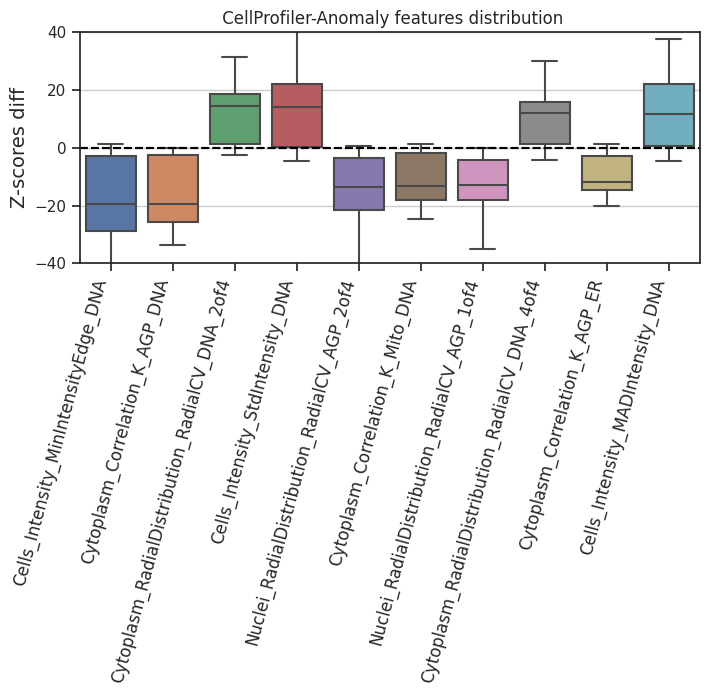

In [168]:
# examine the differences between the anomaly scores and the cellprofiler features
AnomalyDiffsFromCP = reps['Anomaly'].copy()
# AnomalyDiffsFromCP[features] = np.sign(reps['CellProfiler'][features]) * np.log1p(np.abs(reps['CellProfiler'][features])) - np.sign(reps['Anomaly'][features]) * np.log1p(np.abs(reps['Anomaly'][features]))
AnomalyDiffsFromCP[features] = np.abs( reps['CellProfiler'][features] - reps['Anomaly'][features])
# AnomalyDiffsFromCP[features] = np.abs(reps['Anomaly'][features]) - np.abs(reps['CellProfiler'][features])
AnomalyDiffsFromCP[features] = reps['Anomaly'][features] - reps['CellProfiler'][features]

# AnomalyDiffsFromCP[features] = np.sign(AnomalyDiffsFromCP[features]) * np.log1p(np.abs(AnomalyDiffsFromCP[features]))

# # for r in reps_normalized:
data_moa = AnomalyDiffsFromCP[AnomalyDiffsFromCP[moa_col].isin(moas_to_examine)]

# top_features = data_moa[features].mean(axis=0).sort_values(ascending=False).index[:10]
means = data_moa[features].median(axis=0)
# data_moa['mean_values'] = data_moa[features_to_show].mean(axis=1)

stds = data_moa[features].std(axis=0)
# data_moa[features_to_show].sort_values(by='mean_values', key=abs,inplace=True)
top_features = means.sort_values(ascending=False, key=abs).index[:10]
# if r == 'Anomaly':
top_features_to_show = top_features
mean_top_feature_values = means[top_features_to_show]
std_top_feature_values = stds[top_features_to_show]

cols = [cpd_col, moa_col] + top_features_to_show.tolist()
data_moa_top_features = data_moa[cols]
melted_rep = data_moa_top_features.melt(id_vars=[cpd_col, moa_col], value_vars=top_features_to_show, var_name='feature', value_name='value')

fig = plt.figure(figsize=(8,3))
sns.boxplot(x='feature', y='value', data=melted_rep, ax=fig.gca())
plt.axhline(0, color='black', linestyle='--')
plt.xticks(rotation=90, fontsize=8)
plt.grid(axis='y')
plt.title(f' CellProfiler-Anomaly features distribution')

if dataset == 'LINCS':
    plt.ylim(-10, 10)
else:
    plt.ylim(-40, 40)

    
plt.axhline(0, color='black', linestyle='--')
plt.ylabel('Z-scores diff', fontsize=14)

plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=75, ha='right', fontsize=12)
plt.gca().set(xlabel=None)
plt.show()
plt.show()



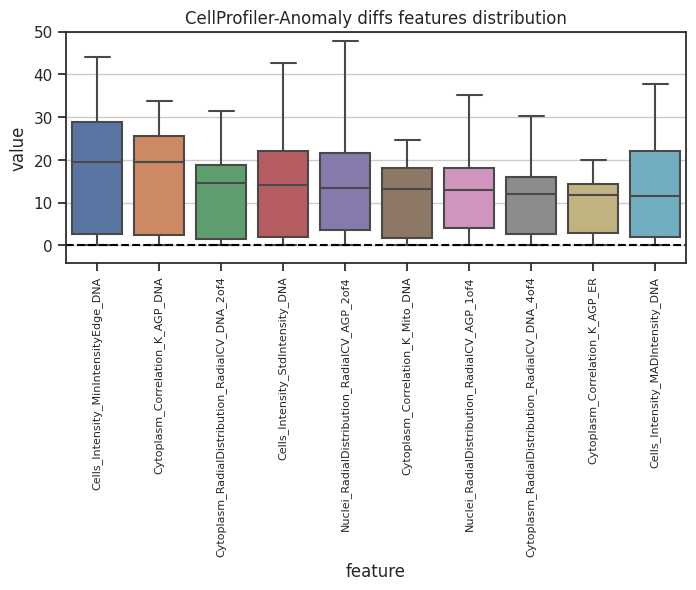

In [169]:
# examine the differences between the anomaly scores and the cellprofiler features
AnomalyDiffsFromCP = reps['Anomaly'].copy()
# AnomalyDiffsFromCP[features] = np.sign(reps['CellProfiler'][features]) * np.log1p(np.abs(reps['CellProfiler'][features])) - np.sign(reps['Anomaly'][features]) * np.log1p(np.abs(reps['Anomaly'][features]))
# AnomalyDiffsFromCP[features] = np.sign(reps['CellProfiler'][features]) * np.abs(reps['CellProfiler'][features]) - np.sign(reps['Anomaly'][features]) * np.abs(reps['Anomaly'][features])
AnomalyDiffsFromCP[features] = np.abs( reps['Anomaly'][features] - reps['CellProfiler'][features])
# AnomalyDiffsFromCP[features] = reps['Anomaly'][features] - reps['CellProfiler'][features]

# AnomalyDiffsFromCP[features] = np.sign(AnomalyDiffsFromCP[features]) * np.log1p(np.abs(AnomalyDiffsFromCP[features]))

# # for r in reps_normalized:
data_moa = AnomalyDiffsFromCP[AnomalyDiffsFromCP[moa_col].isin(moas_to_examine)]

# top_features = data_moa[features].mean(axis=0).sort_values(ascending=False).index[:10]
means = data_moa[features].median(axis=0)
# data_moa['mean_values'] = data_moa[features_to_show].mean(axis=1)

stds = data_moa[features].std(axis=0)
# data_moa[features_to_show].sort_values(by='mean_values', key=abs,inplace=True)
top_features = means.sort_values(ascending=False, key=abs).index[:10]
# if r == 'Anomaly':
top_features_to_show = top_features
mean_top_feature_values = means[top_features_to_show]
std_top_feature_values = stds[top_features_to_show]

cols = [cpd_col, moa_col] + top_features_to_show.tolist()
data_moa_top_features = data_moa[cols]
melted_rep = data_moa_top_features.melt(id_vars=[cpd_col, moa_col], value_vars=top_features_to_show, var_name='feature', value_name='value')
fig = plt.figure(figsize=(8,3))
sns.boxplot(x='feature', y='value', data=melted_rep, ax=fig.gca())
plt.axhline(0, color='black', linestyle='--')
plt.xticks(rotation=90, fontsize=8)
plt.grid(axis='y')
plt.title(f'CellProfiler-Anomaly diffs features distribution')

if dataset == 'LINCS':
    plt.ylim(-10, 10)
else:
    plt.ylim(-4, 50)
plt.show()


### With Whole-Plate normalization

CellProfiler atpase inhibitor 76
Anomaly atpase inhibitor 76
*** Cells_Texture_DifferenceEntropy_RNA_10_0
* Cytoplasm_Granularity_4_AGP


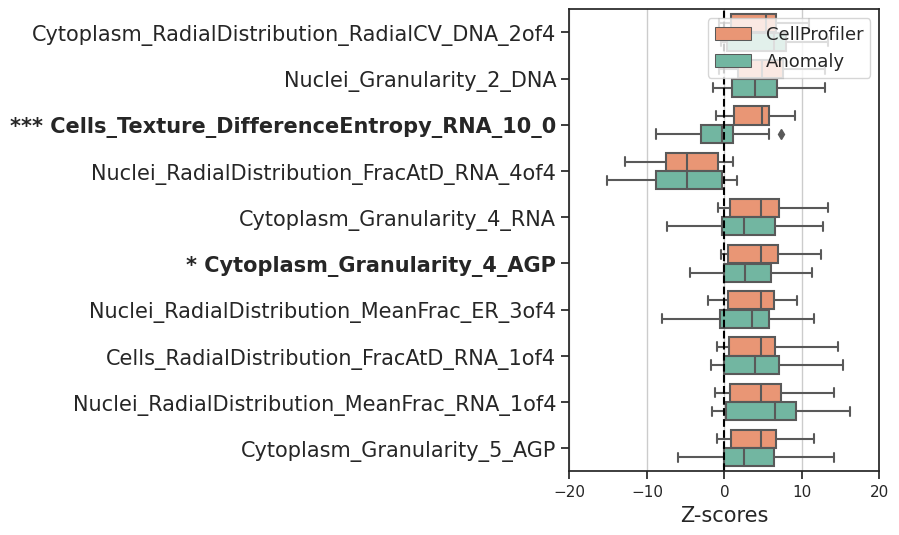

In [170]:
for m in moas_to_examine:
    means = {}
    stds = {}
    melted_both = []
    for r in reps_normalized:
            
        # data_moa = reps_normalized[r][reps_normalized[r][moa_col]==m]
        data_moa = reps_normalized[r][reps_normalized[r][moa_col].isin([m])]
        print(f'{r} {m} {data_moa.shape[0]}')


        # top_features = data_moa[features].mean(axis=0).sort_values(ascending=False).index[:10]
        means[r] = data_moa[features].median(axis=0)
        # data_moa['mean_values'] = data_moa[features_to_show].mean(axis=1)
        
        stds[r] = data_moa[features].std(axis=0)
        # data_moa[features_to_show].sort_values(by='mean_values', key=abs,inplace=True)
        top_features = means[r].sort_values(ascending=False, key=abs).index[:10]
        if r == 'CellProfiler':
            top_features_to_show = top_features
            mean_top_feature_values = means[r][top_features_to_show]
            std_top_feature_values = stds[r][top_features_to_show]

        cols = [cpd_col, moa_col] + top_features_to_show.tolist()
        data_moa_top_features = data_moa[cols]
        melted_rep = data_moa_top_features.melt(id_vars=[cpd_col, moa_col], value_vars=top_features_to_show, var_name='Feature', value_name='Value')
        melted_rep['rep'] = r
        melted_both.append(melted_rep)
        # sns.boxplot(x='feature', y='value', data=melted_rep)
        # plt.axhline(0, color='black', linestyle='--')
        # plt.xticks(rotation=90, fontsize=8)
        # plt.grid(axis='y')
        # plt.title(f'{r} features distribution')
        # plt.ylim(-50, 150)
        # plt.show()

    melted_both = pd.concat(melted_both)
    save_path = f'{fig_dir}features_distribution_ranked_by_cellprofiler_norm.png'
    # melted_both = pd.concat(melted_both)
    plot_important_features(melted_both,save_path=save_path,ylim=(-20,20),hue_order=hue_order)
    # sns.boxplot(x='feature', y='value', hue='rep', data=melted_both,hue_order=hue_order)
    # plt.axhline(0, color='black', linestyle='--')
    # plt.xticks(rotation=90, fontsize=10)
    # plt.grid(axis='y')
    # plt.title(f'features distribution')
    # plt.ylim(-20, 20)
    # plt.show()

CellProfiler atpase inhibitor 76
Anomaly atpase inhibitor 76


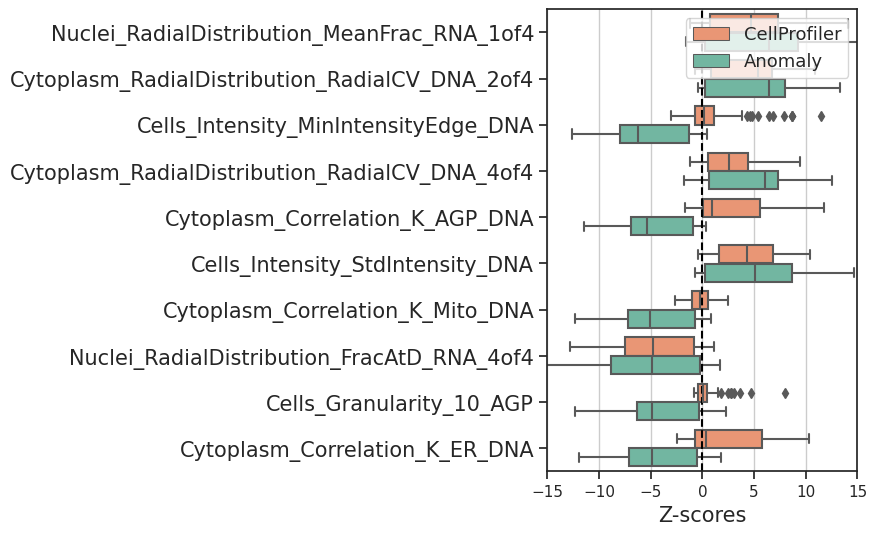

In [171]:
# melt the dataframes and show the distribution of the features for each MOA (same as above, this time with seaborn)
data_moa = reps_normalized['Anomaly'][reps_normalized['Anomaly'][moa_col].isin(moas_to_examine)]
# top_features = data_moa[features].mean(axis=0).sort_values(ascending=False).index[:10]
means = data_moa[features].median(axis=0)
# data_moa['mean_values'] = data_moa[features_to_show].mean(axis=1)

stds = data_moa[features].std(axis=0)
# data_moa[features_to_show].sort_values(by='mean_values', key=abs,inplace=True)
top_features = means.sort_values(ascending=False, key=abs).index[:10]

top_features_to_show = top_features
mean_top_feature_values = means[top_features_to_show]
std_top_feature_values = stds[top_features_to_show]

for m in moas_to_examine:
    means = {}
    stds = {}
    melted_both = []

    for r in reps_normalized.keys():
            
        data_moa = reps_normalized[r][reps_normalized[r][moa_col]==m]
        print(f'{r} {m} {data_moa.shape[0]}')

        # top_features = data_moa[features].mean(axis=0).sort_values(ascending=False).index[:10]
        means[r] = data_moa[features].median(axis=0)
        # data_moa['mean_values'] = data_moa[features_to_show].mean(axis=1)
        
        stds[r] = data_moa[features].std(axis=0)
        # data_moa[features_to_show].sort_values(by='mean_values', key=abs,inplace=True)
        top_features = means[r].sort_values(ascending=False, key=abs).index[:10]
        if r == 'Anomaly':
            # top_features_to_show = top_features
            mean_top_feature_values = means[r][top_features_to_show]
            std_top_feature_values = stds[r][top_features_to_show]

        cols = [cpd_col, moa_col] + top_features_to_show.tolist()
        data_moa_top_features = data_moa[cols]
        melted_rep = data_moa_top_features.melt(id_vars=[cpd_col, moa_col], value_vars=top_features_to_show, var_name='Feature', value_name='Value')
        melted_rep['rep'] = r
        melted_both.append(melted_rep)

        # sns.boxplot(x='feature', y='value', data=melted_rep)
        # plt.axhline(0, color='black', linestyle='--')
        # plt.xticks(rotation=90, fontsize=10)
        # plt.grid(axis='y')
        # plt.title(f'{r} features distribution')
        # plt.ylim(-50, 150)
        # plt.show()
        
    melted_both = pd.concat(melted_both)
    save_path = f'{fig_dir}features_distribution_ranked_by_anomaly_norm.png'
    
    plot_important_features(melted_both,save_path=save_path,ylim=(-15,15),hue_order=hue_order)
    # sns.boxplot(x='feature', y='value', hue='rep', data=melted_both,hue_order=hue_order)
    # plt.axhline(0, color='black', linestyle='--')
    # plt.xticks(rotation=90, fontsize=8)
    # plt.grid(axis='y')
    # plt.title(f'features distribution')
    # plt.ylim(-10, 20)
    # plt.show()

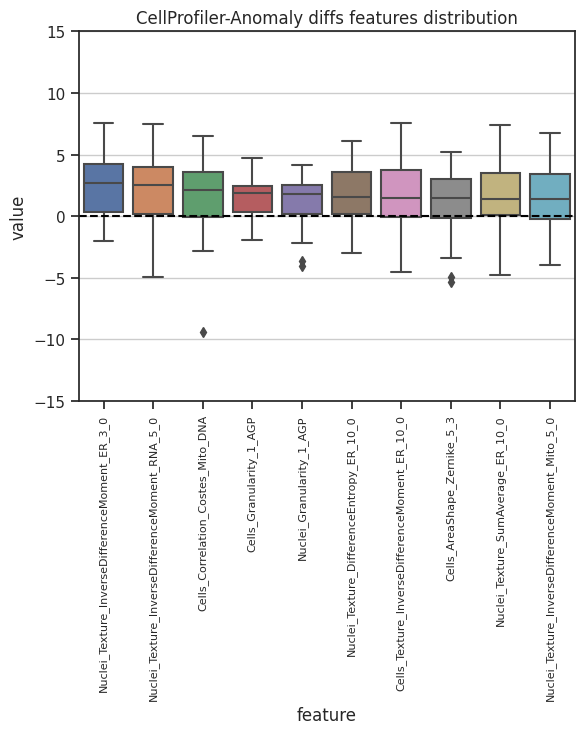

In [172]:
# examine the differences between the anomaly scores and the cellprofiler features
AnomalyDiffsFromCP = reps_normalized['Anomaly'].copy()
# AnomalyDiffsFromCP[features] = np.sign(reps_normalized['CellProfiler'][features]) * np.log1p(np.abs(reps_normalized['CellProfiler'][features])) - np.sign(reps_normalized['Anomaly'][features]) * np.log1p(np.abs(reps_normalized['Anomaly'][features]))
# AnomalyDiffsFromCP[features] = np.sign(reps_normalized['CellProfiler'][features]) * np.abs(reps_normalized['CellProfiler'][features]) - np.sign(reps_normalized['Anomaly'][features]) * np.abs(reps_normalized['Anomaly'][features])
AnomalyDiffsFromCP[features] = np.abs(reps_normalized['CellProfiler'][features]) -  np.abs(reps_normalized['Anomaly'][features])
# AnomalyDiffsFromCP[features] = reps['Anomaly'][features] - reps['CellProfiler'][features]

# AnomalyDiffsFromCP[features] = np.sign(AnomalyDiffsFromCP[features]) * np.log1p(np.abs(AnomalyDiffsFromCP[features]))

# # for r in reps_normalized:
data_moa = AnomalyDiffsFromCP[AnomalyDiffsFromCP[moa_col].isin(moas_to_examine)]

# top_features = data_moa[features].mean(axis=0).sort_values(ascending=False).index[:10]
means = data_moa[features].median(axis=0)
# data_moa['mean_values'] = data_moa[features_to_show].mean(axis=1)

stds = data_moa[features].std(axis=0)
# data_moa[features_to_show].sort_values(by='mean_values', key=abs,inplace=True)
top_features = means.sort_values(ascending=False).index[:10]
# if r == 'Anomaly':
top_features_to_show = top_features
mean_top_feature_values = means[top_features_to_show]
std_top_feature_values = stds[top_features_to_show]

cols = [cpd_col, moa_col] + top_features_to_show.tolist()
data_moa_top_features = data_moa[cols]
melted_rep = data_moa_top_features.melt(id_vars=[cpd_col, moa_col], value_vars=top_features_to_show, var_name='feature', value_name='value')
sns.boxplot(x='feature', y='value', data=melted_rep)
plt.axhline(0, color='black', linestyle='--')
plt.xticks(rotation=90, fontsize=8)
plt.grid(axis='y')
plt.title(f'CellProfiler-Anomaly diffs features distribution')

if dataset == 'LINCS':
    plt.ylim(-10, 10)
else:
    plt.ylim(-15, 15)
plt.show()

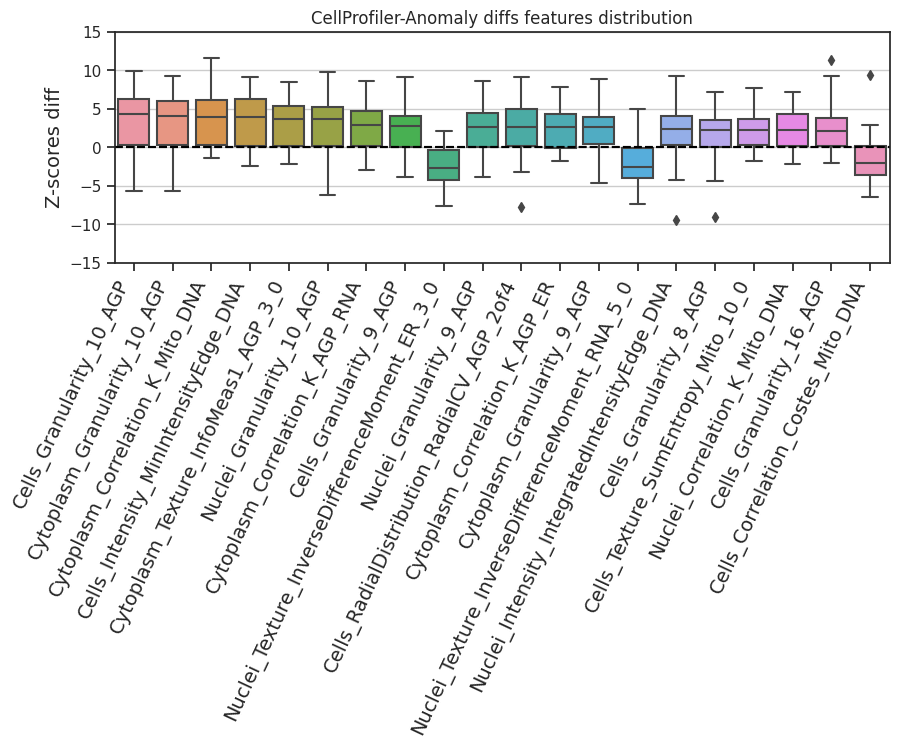

In [173]:
# examine the differences between the anomaly scores and the cellprofiler features
AnomalyDiffsFromCP = reps_normalized['Anomaly'].copy()
# AnomalyDiffsFromCP[features] = np.sign(reps_normalized['CellProfiler'][features]) * np.log1p(np.abs(reps_normalized['CellProfiler'][features])) - np.sign(reps_normalized['Anomaly'][features]) * np.log1p(np.abs(reps_normalized['Anomaly'][features]))
# AnomalyDiffsFromCP[features] = np.sign(reps_normalized['CellProfiler'][features]) * np.abs(reps_normalized['CellProfiler'][features]) - np.sign(reps_normalized['Anomaly'][features]) * np.abs(reps_normalized['Anomaly'][features])
AnomalyDiffsFromCP[features] = np.abs(reps_normalized['Anomaly'][features]) - np.abs(reps_normalized['CellProfiler'][features]) 
# AnomalyDiffsFromCP[features] = reps['Anomaly'][features] - reps['CellProfiler'][features]

# AnomalyDiffsFromCP[features] = np.sign(AnomalyDiffsFromCP[features]) * np.log1p(np.abs(AnomalyDiffsFromCP[features]))

# # for r in reps_normalized:
data_moa = AnomalyDiffsFromCP[AnomalyDiffsFromCP[moa_col].isin(moas_to_examine)]

# top_features = data_moa[features].mean(axis=0).sort_values(ascending=False).index[:10]
means = data_moa[features].median(axis=0)
# data_moa['mean_values'] = data_moa[features_to_show].mean(axis=1)

stds = data_moa[features].std(axis=0)
# data_moa[features_to_show].sort_values(by='mean_values', key=abs,inplace=True)
top_features = means.sort_values(ascending=False, key=abs).index[:20]
# if r == 'Anomaly':
top_features_to_show = top_features
mean_top_feature_values = means[top_features_to_show]
std_top_feature_values = stds[top_features_to_show]

cols = [cpd_col, moa_col] + top_features_to_show.tolist()
data_moa_top_features = data_moa[cols]
melted_rep = data_moa_top_features.melt(id_vars=[cpd_col, moa_col], value_vars=top_features_to_show, var_name='feature', value_name='value')

fig = plt.figure(figsize=(10,3))
sns.boxplot(x='feature', y='value', data=melted_rep, ax=fig.gca())
plt.axhline(0, color='black', linestyle='--')
plt.xticks(rotation=90, fontsize=8)
plt.grid(axis='y')
plt.title(f'CellProfiler-Anomaly diffs features distribution')

if dataset == 'LINCS':
    plt.ylim(-10, 10)
else:
    plt.ylim(-15, 15)
# plt.show()

plt.axhline(0, color='black', linestyle='--')
plt.ylabel('Z-scores diff', fontsize=14)

plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=65, ha='right', fontsize=14)
plt.gca().set(xlabel=None)
plt.show()
# plt.grid(axis='y')
# plt.title(f'features distribution')
# plt.ylim(ylim)


CellProfiler atpase inhibitor 76
Anomaly atpase inhibitor 76


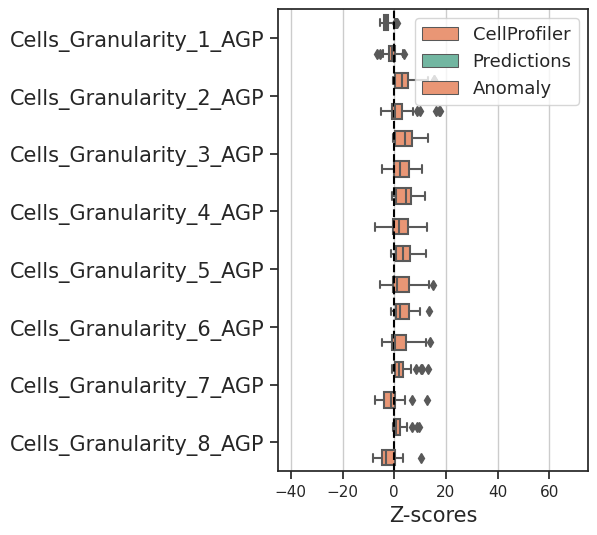

In [174]:
# melt the dataframes and show the distribution of the features for each MOA (same as above, this time with seaborn)

for m in moas_to_examine:
    means = {}
    stds = {}
    melted_both = []
    for r in reps_normalized:
            
        # data_moa = reps_normalized[r][reps_normalized[r][moa_col]==m]
        data_moa = reps_normalized[r][reps_normalized[r][moa_col].isin([m])]
        print(f'{r} {m} {data_moa.shape[0]}')


        # top_features = data_moa[features].mean(axis=0).sort_values(ascending=False).index[:10]
        means[r] = data_moa[granurality_features].median(axis=0)
        # data_moa['mean_values'] = data_moa[features_to_show].mean(axis=1)
        
        stds[r] = data_moa[granurality_features].std(axis=0)
        # data_moa[features_to_show].sort_values(by='mean_values', key=abs,inplace=True)
        # top_features = means[r].sort_values(ascending=False, key=abs).index[:10]
        # if r == 'CellProfiler':
            # top_features_to_show = top_features
            # mean_top_feature_values = means[r][top_features_to_show]
            # std_top_feature_values = stds[r][top_features_to_show]

        cols = [cpd_col, moa_col] + granurality_features
        data_moa_top_features = data_moa[cols]
        
        melted_rep = data_moa_top_features.melt(id_vars=[cpd_col, moa_col], value_vars=granurality_features, var_name='Feature', value_name='Value')
        melted_rep['rep'] = r
        melted_both.append(melted_rep)
        # sns.boxplot(x='feature', y='value', data=melted_rep)
        # plt.axhline(0, color='black', linestyle='--')
        # plt.xticks(rotation=90, fontsize=8)
        # plt.grid(axis='y')
        # plt.title(f'{r} features distribution')
        # plt.ylim(-50, 150)
        # plt.show()

    melted_both = pd.concat(melted_both)
    save_path = f'{fig_dir}gran_distribution_ranked_by_cellprofiler_no_norm.png'
    # melted_both = pd.concat(melted_both)
    plot_important_features(melted_both,save_path=save_path, ylim = (-45, 75))    

In [175]:
# melt the dataframes and show the distribution of the features for each MOA (same as above, this time with seaborn)


data_moa = reps_normalized['Anomaly'][reps_normalized['Anomaly'][moa_col].isin(moas_to_examine)]
# top_features = data_moa[features].mean(axis=0).sort_values(ascending=False).index[:10]
means = data_moa[features].mean(axis=0)
# data_moa['mean_values'] = data_moa[features_to_show].mean(axis=1)

stds = data_moa[features].std(axis=0)
# data_moa[features_to_show].sort_values(by='mean_values', key=abs,inplace=True)
top_features = means.sort_values(ascending=False, key=abs).index[:20]

top_features_to_show = top_features
mean_top_feature_values = means[top_features_to_show]
std_top_feature_values = stds[top_features_to_show]

for m in moas_to_examine:
    means = {}
    stds = {}
    melted_both = []

    for r in ['Anomaly','Predictions','CellProfiler']:
            
        data_moa = reps_normalized[r][reps_normalized[r][moa_col]==m]
        print(f'{r} {m} {data_moa.shape[0]}')

        # top_features = data_moa[features].mean(axis=0).sort_values(ascending=False).index[:10]
        means[r] = data_moa[features].mean(axis=0)
        # data_moa['mean_values'] = data_moa[features_to_show].mean(axis=1)
        
        stds[r] = data_moa[features].std(axis=0)
        # data_moa[features_to_show].sort_values(by='mean_values', key=abs,inplace=True)
        top_features = means[r].sort_values(ascending=False, key=abs).index[:20]
        if r == 'Anomaly':
            top_features_to_show = top_features
            mean_top_feature_values = means[r][top_features_to_show]
            std_top_feature_values = stds[r][top_features_to_show]

        cols = [cpd_col, moa_col] + top_features_to_show.tolist()
        data_moa_top_features = data_moa[cols]
        melted_rep = data_moa_top_features.melt(id_vars=[cpd_col, moa_col], value_vars=top_features_to_show, var_name='feature', value_name='value')
        melted_rep['rep'] = r
        melted_both.append(melted_rep)

        # sns.boxplot(x='feature', y='value', data=melted_rep)
        # plt.axhline(0, color='black', linestyle='--')
        # plt.xticks(rotation=90, fontsize=10)
        # plt.grid(axis='y')
        # plt.title(f'{r} features distribution')
        # plt.ylim(-50, 150)
        # plt.show()
        
    melted_both = pd.concat(melted_both)
    sns.boxplot(x='feature', y='value', hue='rep', data=melted_both, hue_order=hue_order)
    plt.axhline(0, color='black', linestyle='--')
    plt.xticks(rotation=90, fontsize=8)
    plt.grid(axis='y')
    plt.title(f'features distribution')
    plt.ylim(-15, 20)
    plt.show()


Anomaly atpase inhibitor 76


KeyError: 'Predictions'

In [ ]:
# examine the differences between the anomaly scores and the cellprofiler features
AnomalyDiffsFromCP = reps_normalized['Anomaly'].copy()
# AnomalyDiffsFromCP[features] = reps_normalized['Anomaly'][features] - reps_normalized['CellProfiler'][features]
# AnomalyDiffsFromCP[features] = np.sign(reps_normalized['CellProfiler'][features]) * np.log1p(np.abs(reps_normalized['CellProfiler'][features])) - np.sign(reps_normalized['Anomaly'][features]) * np.log1p(np.abs(reps_normalized['Anomaly'][features]))
AnomalyDiffsFromCP[features] = np.sign(reps_normalized['CellProfiler'][features]) * np.abs(reps_normalized['CellProfiler'][features]) - np.sign(reps_normalized['Anomaly'][features]) * np.abs(reps_normalized['Anomaly'][features])
# # for r in reps_normalized:
data_moa = AnomalyDiffsFromCP[AnomalyDiffsFromCP[moa_col].isin(moas_to_examine)]
# melted_rep = data_moa.melt(id_vars=[cpd_col, moa_col], value_vars=features, var_name='feature', value_name='value')
# sns.boxplot(x='feature', y='value', data=melted_rep)
# # plt.xticks(rotation=90, fontsize=4)
# plt.xticks(rotation=90, fontsize=1)
# plt.title(f'Anomaly differences from CellProfiler features distribution')
# plt.show()
    

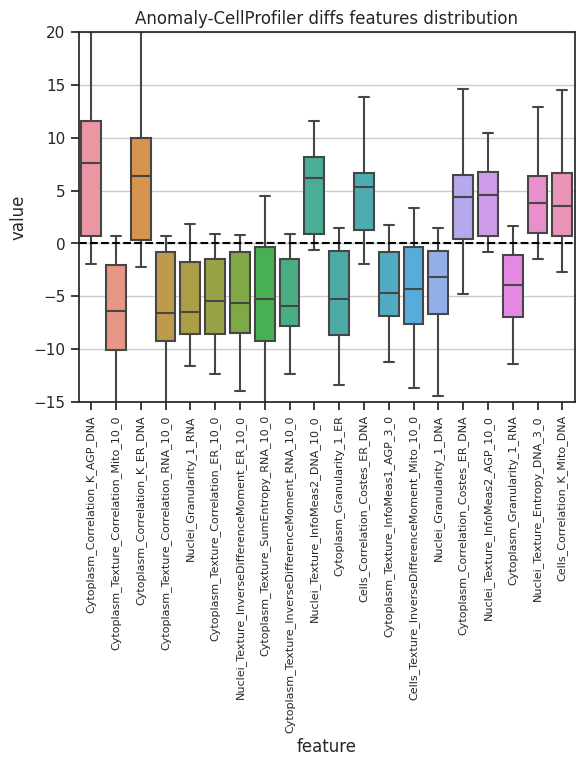

In [ ]:

# data_moa = reps_normalized[r][reps_normalized[r][moa_col].isin(moas_to_examine)]
# print(f'{r} {m} {data_moa.shape[0]}')


# top_features = data_moa[features].mean(axis=0).sort_values(ascending=False).index[:10]
means = data_moa[features].mean(axis=0)
# data_moa['mean_values'] = data_moa[features_to_show].mean(axis=1)

stds = data_moa[features].std(axis=0)
# data_moa[features_to_show].sort_values(by='mean_values', key=abs,inplace=True)
top_features = means.sort_values(ascending=False, key=abs).index[:20]
# if r == 'Anomaly':
top_features_to_show = top_features
mean_top_feature_values = means[top_features_to_show]
std_top_feature_values = stds[top_features_to_show]

cols = [cpd_col, moa_col] + top_features_to_show.tolist()
data_moa_top_features = data_moa[cols]
melted_rep = data_moa_top_features.melt(id_vars=[cpd_col, moa_col], value_vars=top_features_to_show, var_name='feature', value_name='value')
sns.boxplot(x='feature', y='value', data=melted_rep)
plt.axhline(0, color='black', linestyle='--')
plt.xticks(rotation=90, fontsize=8)
plt.grid(axis='y')
plt.title(f'Anomaly-CellProfiler diffs features distribution')

if dataset == 'LINCS':
    plt.ylim(-10, 10)
else:
    plt.ylim(-15, 20)
plt.show()

In [ ]:
# normalize both methods min max to -1 and 1
from sklearn.preprocessing import MinMaxScaler

reps_minmax = {}

scaler = MinMaxScaler(feature_range=(-1, 1))
reps_minmax['Anomaly'] = reps['Anomaly'].copy()
reps_minmax['CellProfiler'] = reps['CellProfiler'].copy()
reps_minmax['Anomaly'][features] = scaler.fit_transform(reps_normalized['Anomaly'][features])
reps_minmax['CellProfiler'][features] = scaler.fit_transform(reps_normalized['CellProfiler'][features])


Anomaly atpase inhibitor 76
CellProfiler atpase inhibitor 76


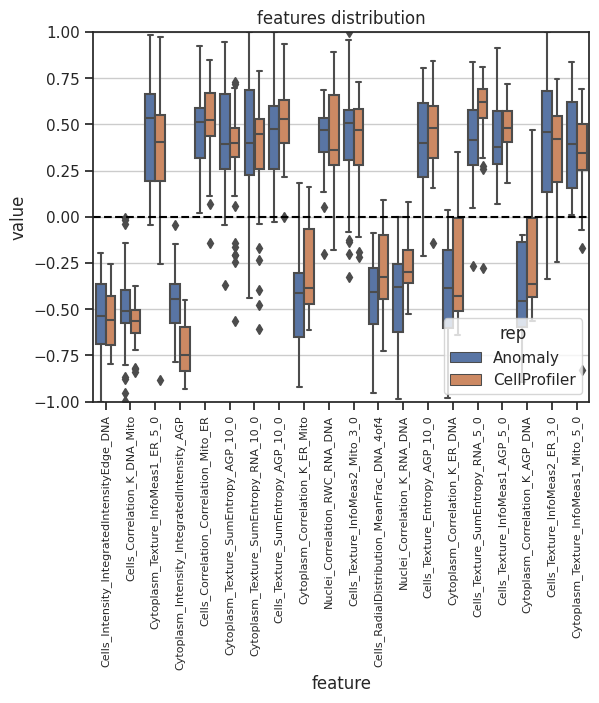

In [ ]:
melted_both = []
for r in ['Anomaly','CellProfiler']:
        
    data_moa = reps_minmax[r][reps_minmax[r][moa_col].isin(moas_to_examine)]
    print(f'{r} {m} {data_moa.shape[0]}')


    # top_features = data_moa[features].mean(axis=0).sort_values(ascending=False).index[:10]
    means[r] = data_moa[features].mean(axis=0)
    # data_moa['mean_values'] = data_moa[features_to_show].mean(axis=1)
    
    stds[r] = data_moa[features].std(axis=0)
    # data_moa[features_to_show].sort_values(by='mean_values', key=abs,inplace=True)
    top_features = means[r].sort_values(ascending=False, key=abs).index[:20]
    if r == 'Anomaly':
        top_features_to_show = top_features
        mean_top_feature_values = means[r][top_features_to_show]
        std_top_feature_values = stds[r][top_features_to_show]

    cols = [cpd_col, moa_col] + top_features_to_show.tolist()
    data_moa_top_features = data_moa[cols]
    melted_rep = data_moa_top_features.melt(id_vars=[cpd_col, moa_col], value_vars=top_features_to_show, var_name='feature', value_name='value')
    melted_rep['rep'] = r
    melted_both.append(melted_rep)


melted_both = pd.concat(melted_both)
sns.boxplot(x='feature', y='value', hue='rep', data=melted_both)
plt.axhline(0, color='black', linestyle='--')
plt.xticks(rotation=90, fontsize=8)
plt.grid(axis='y')
plt.title(f'features distribution')
plt.ylim(-1, 1)
plt.show()


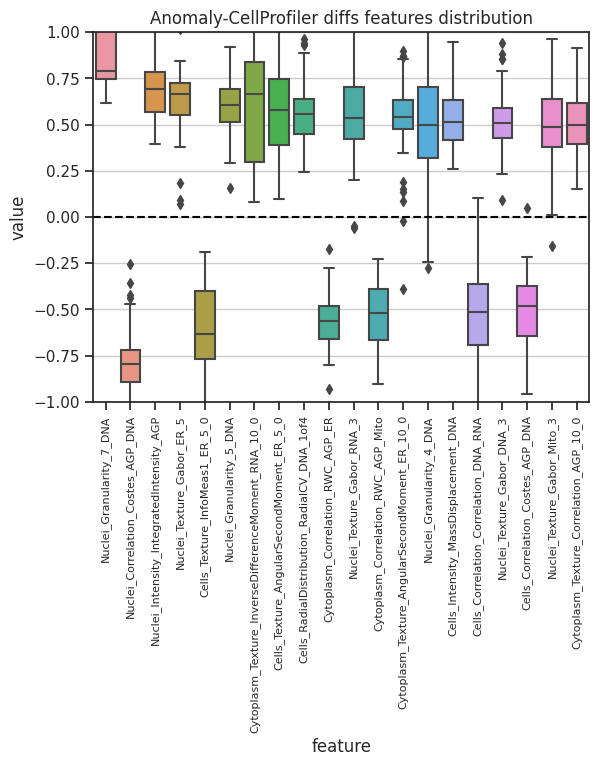

In [ ]:

# examine the differences between the anomaly scores and the cellprofiler features
AnomalyDiffsFromCP = reps_minmax['Anomaly'].copy()
AnomalyDiffsFromCP[features] = reps_minmax['Anomaly'][features] - reps_minmax['CellProfiler'][features]

# for r in reps_normalized:
data_moa = AnomalyDiffsFromCP[AnomalyDiffsFromCP[moa_col].isin(moas_to_examine)]

means = data_moa[features].mean(axis=0)
stds = data_moa[features].std(axis=0)

top_features = means.sort_values(ascending=False, key=abs).index[:20]
# if r == 'Anomaly':
top_features_to_show = top_features
mean_top_feature_values = means[top_features_to_show]
std_top_feature_values = stds[top_features_to_show]

cols = [cpd_col, moa_col] + top_features_to_show.tolist()
data_moa_top_features = data_moa[cols]
melted_rep = data_moa_top_features.melt(id_vars=[cpd_col, moa_col], value_vars=top_features_to_show, var_name='feature', value_name='value')
sns.boxplot(x='feature', y='value', data=melted_rep)
plt.axhline(0, color='black', linestyle='--')
plt.xticks(rotation=90, fontsize=8)
plt.grid(axis='y')
plt.title(f'Anomaly-CellProfiler diffs features distribution')
plt.ylim(-1, 1)
plt.show()

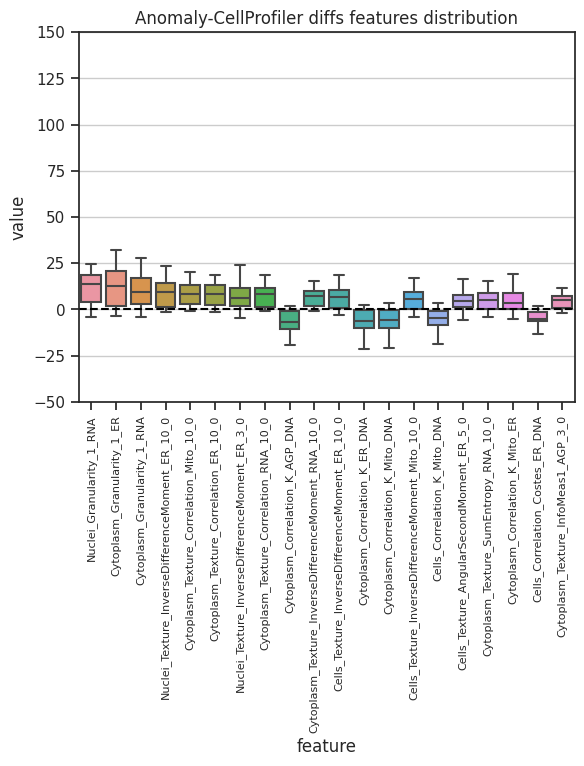

In [ ]:
# examine the differences between the anomaly scores and the cellprofiler features
AnomalyDiffsFromCP = reps_normalized['Anomaly'].copy()
AnomalyDiffsFromCP[features] = (reps_normalized['Anomaly'][features] - reps_normalized['CellProfiler'][features]) / (1+reps_normalized['CellProfiler'][features].mean())

# for r in reps_normalized:
data_moa = AnomalyDiffsFromCP[AnomalyDiffsFromCP[moa_col].isin(moas_to_examine)]
means = data_moa[features].mean(axis=0)
stds = data_moa[features].std(axis=0)

top_features = means.sort_values(ascending=False, key=abs).index[:20]
# if r == 'Anomaly':
top_features_to_show = top_features
mean_top_feature_values = means[top_features_to_show]
std_top_feature_values = stds[top_features_to_show]

cols = [cpd_col, moa_col] + top_features_to_show.tolist()
data_moa_top_features = data_moa[cols]
melted_rep = data_moa_top_features.melt(id_vars=[cpd_col, moa_col], value_vars=top_features_to_show, var_name='feature', value_name='value')
sns.boxplot(x='feature', y='value', data=melted_rep)
plt.axhline(0, color='black', linestyle='--')
plt.xticks(rotation=90, fontsize=8)
plt.grid(axis='y')
plt.title(f'Anomaly-CellProfiler diffs features distribution')
plt.ylim(-50, 150)
plt.show()

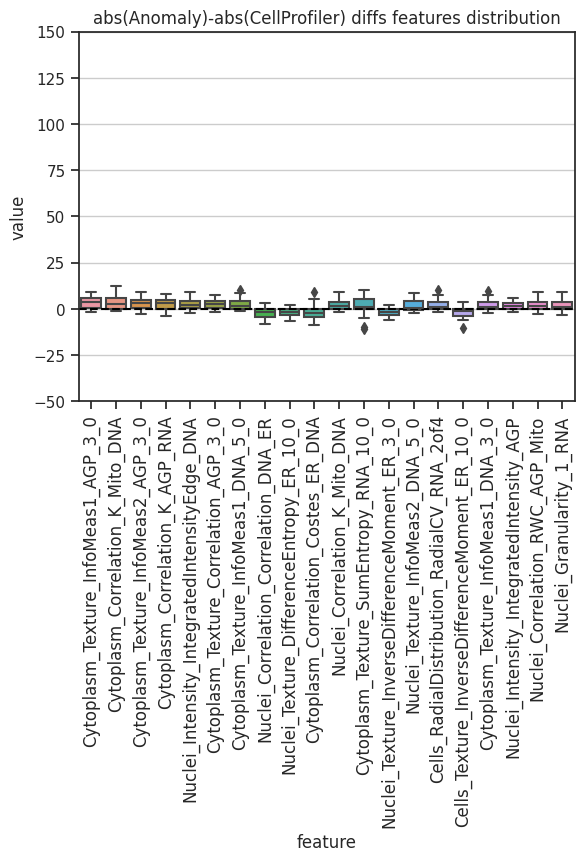

In [ ]:
AnomalyDiffsFromCP_abs = reps_normalized['Anomaly'].copy()
AnomalyDiffsFromCP_abs[features] = np.abs(reps_normalized['Anomaly'][features]) - np.abs(reps_normalized['CellProfiler'][features])

for m in moas_to_examine:
    data_moa = AnomalyDiffsFromCP_abs[AnomalyDiffsFromCP_abs[moa_col] == m]

        
    # top_features = data_moa[features].mean(axis=0).sort_values(ascending=False).index[:10]
    means = data_moa[features].mean(axis=0)
    # data_moa['mean_values'] = data_moa[features_to_show].mean(axis=1)

    stds = data_moa[features].std(axis=0)
    # data_moa[features_to_show].sort_values(by='mean_values', key=abs,inplace=True)
    top_features = means.sort_values(ascending=False, key=abs).index[:20]
    # if r == 'Anomaly':
    top_features_to_show = top_features
    mean_top_feature_values = means[top_features_to_show]
    std_top_feature_values = stds[top_features_to_show]

    cols = [cpd_col, moa_col] + top_features_to_show.tolist()
    data_moa_top_features = data_moa[cols]
    melted_rep = data_moa_top_features.melt(id_vars=[cpd_col, moa_col], value_vars=top_features_to_show, var_name='feature', value_name='value')
    sns.boxplot(x='feature', y='value', data=melted_rep)
    plt.axhline(0, color='black', linestyle='--')
    plt.xticks(rotation=90, fontsize=12)
    plt.grid(axis='y')
    plt.title(f'abs(Anomaly)-abs(CellProfiler) diffs features distribution')
    plt.ylim(-50, 150)
    plt.show()




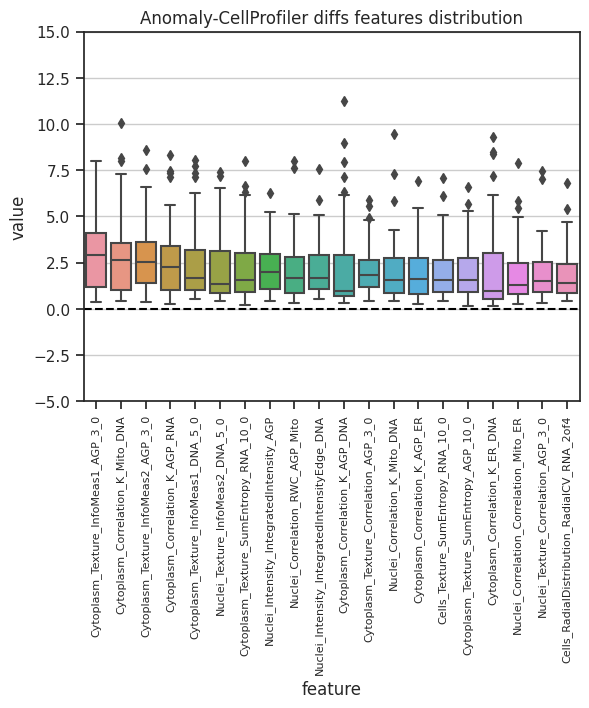

In [ ]:
AnomalyDiffsFromCP_abs = reps_normalized['Anomaly'].copy()
AnomalyDiffsFromCP_abs[features] = (1+np.abs(reps_normalized['Anomaly'][features]) ) / (1+ np.abs(reps_normalized['CellProfiler'][features]))

for m in moas_to_examine:
    data_moa = AnomalyDiffsFromCP_abs[AnomalyDiffsFromCP_abs[moa_col] == m]

        
    # top_features = data_moa[features].mean(axis=0).sort_values(ascending=False).index[:10]
    means = data_moa[features].mean(axis=0)
    # data_moa['mean_values'] = data_moa[features_to_show].mean(axis=1)

    stds = data_moa[features].std(axis=0)
    # data_moa[features_to_show].sort_values(by='mean_values', key=abs,inplace=True)
    top_features = means.sort_values(ascending=False, key=abs).index[:20]
    # if r == 'Anomaly':
    top_features_to_show = top_features
    mean_top_feature_values = means[top_features_to_show]
    std_top_feature_values = stds[top_features_to_show]

    cols = [cpd_col, moa_col] + top_features_to_show.tolist()
    data_moa_top_features = data_moa[cols]
    melted_rep = data_moa_top_features.melt(id_vars=[cpd_col, moa_col], value_vars=top_features_to_show, var_name='feature', value_name='value')
    sns.boxplot(x='feature', y='value', data=melted_rep)
    plt.axhline(0, color='black', linestyle='--')
    plt.xticks(rotation=90, fontsize=8)
    plt.grid(axis='y')
    plt.title(f'Anomaly-CellProfiler diffs features distribution')
    plt.ylim(-5, 15)
    plt.show()


